# Regresia logistică multinomială

**Termen de predare: 22 decembrie 2024, ora 23:00**

Această temă vine ca urmare a laboratorului 2 (regresia logistică binară) și este construită similar. Se vor folosi type annotations pentru variabile, parametrii tuturor funcțiilor, tipuri de retur. Se vor folosi docstrings pentru toate funcțiile. Neîndeplinirea acestei cerințe duce la înjumătățirea punctajului.

Se acordă doua puncte din oficiu. Fișierul va fi denumit tema3_ia_nume_prenume.ipynb. Verificați înainte de trimitere faptul ca execuția celulelor de sus în jos funcționează corespunzător. Aserțiunile sunt obligatoriu a fi indeplinite. Suplimentar, puteti face si alte verificari.

Resurse utile:

[1] [Cross entropy for dummies](https://towardsdatascience.com/cross-entropy-for-dummies-5189303c7735)

[2] [Understanding logistic regression](https://towardsdatascience.com/understanding-logistic-regression-step-by-step-704a78be7e0a)

[3] [Cross entropy log loss and intuition behind it](https://towardsdatascience.com/cross-entropy-log-loss-and-intuition-behind-it-364558dca514)

[4] [Cross entropy (a se vedea secţiunea "Relation with log-likelihood")](https://en.wikipedia.org/wiki/Cross_entropy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import pandas as pd
from typing import Union
import tableprint as tab

plt.rc('font', **{'size' : 18})

## Setul de instruire
Vom folosi setul de date MNIST (cel utilizat si pentru regresia logistică binară). Setul de instruire este de forma:

$$\mathcal{S}=\Set{(x^{(i)}, y^{(i)})|1 \leq i \leq m}$$

unde vectorul $x^{(i)}=(x_0^{(i)},x_1^{(i)},\dots,x_n^{(i)})^t \in \mathbb{R}^{n+1}$ si $y^{(i)} \in \Set{0,1}$

De această dată, nu mai păstrăm doar 2 clase pentru antrenare, ci rețeaua noastră va învăța toate cifrele.

In [2]:
path_train: str = './data/mnist_train.csv'
path_test: str = './data/mnist_test.csv'

train_set: np.ndarray = pd.read_csv(path_train, header=None).values
test_set: np.ndarray = pd.read_csv(path_test, header=None).values

assert train_set.shape == (60000, 785)
assert test_set.shape == (10000, 785)
# matrice cu 10.000 linii, pe fiecare linie "insirata" o imagine de 28x28 = 784, prima coloana a liniei in [0,9] - cifra din img

In [3]:
# train_set si test_set sunt matrice care contin pe prima coloana clasa, 
# ca o cifra de la 0 la 9
# imaginea cifrei este pastrata incepand de pe coloana 1 pana la terminare
# Decupati in train_x doar imaginile iar in train_y doar clasa,
# si faceti acelasi lucru si pentru test_x si test_y

train_x, train_y = train_set[:, 1:], train_set[:, 0]
test_x, test_y = test_set[:, 1:], test_set[:, 0]

assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

Similar cu regresia logistică binară, trebuie să normalizăm valorile setului de date și să adăugăm un termen $x_0 = 1$ pentru fiecare imagine a setului de date:

In [4]:
# Prin urmare, adaugam o coloana cu 1 pentru orice x
def add_ones_column(x: np.ndarray) -> np.ndarray:
    """
    Returns a matrix with first column filled with 1 and the other columns being x's columns.
    """
    return np.hstack((np.ones((x.shape[0], 1)), x))

def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means division by 255.
    
    Args:
        x: feature matrix, shape m * n. It will not be changed by this code.
    
    Returns:
        matrix with scaled values between 0 and 1, of same shape
    """
    return x / 255.0

In [5]:
# Numarul de clase (10 cifre in setul de date)
k = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext = add_ones_column(normalize(train_x))
test_x_all_ext = add_ones_column(normalize(test_x))

assert train_x_all_ext.shape == (60000, 785)
assert test_x_all_ext.shape == (10000, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

Regresia logistică multinomială are drept ieșire un vector de probabilități. 

În cazul nostru, vom obține 10 probabilități, fiecare reprezentând siguranța cu care imaginea de intrare aparține cifrei respective. Pentru antrenare, trebuie să comparăm acest vector de probabilități cu clasa corectă. 

Prin urmare, definim funcția `one_hot_encoding` care ne va defini „ground-truth”-ul: pentru o imagine aparținând clasei $c$, un vector cu 10 elemente (numărul de clase posibile), dintre care 9 sunt egale cu 0 iar elementul de pe poziția $c$ egal cu 1 (însemnând, probabilitatea ca imaginea să aparțină clasei $c$ este 1 (suntem siguri de asta), iar probabilitatea să aparțină oricărei alte clase este 0).

In [6]:
def one_hot(val: int, classes: int) -> np.ndarray:
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de lungime K, unde doar pe pozitia val avem o valoare 1
    """
    assert 0 <= val < classes
    result: np.ndarray = np.zeros((1, k))
    result[0, val] = 1
    assert result.shape == (1, classes)
    return result

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

train_y_all : np.ndarray = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all : np.ndarray = np.concatenate([one_hot(int(i), k) for i in test_y])
assert train_y_all.shape == (60000, 10)
assert test_y_all.shape == (10000, 10)
assert np.all((train_y_all != 0) == (train_y_all == 1))

Produsul $X \theta$ (X fiind matricea obținută din datele de intrare, iar theta matricea de parametri ai rețelei) între matricea X de dimensiune (m, n) şi $\theta$ de dimensiune (n, k) va avea dimensiunea (m, k):

In [7]:
def prod(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Product between X of shape (m x n) and theta of shape (n x k)
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    return np.dot(x, theta)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert prod(train_x_all_ext, theta).shape == (m, k)

Funcţia $softmax()$ obține o distribuție de probabilități pentru fiecare intrare. Va avea aceleaşi dimensiuni (m, k) şi trebuie să dea pe fiecare coloană suma 1. Se poate scrie compact calculul ei astfel:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

Termenul de la numitor, $e^{X \theta} \cdot \mathbb{1}_k$, nu mai este o matrice, ci un vector de dimensiunea (m, 1) (practic se realizează suma pe fiecare linie). Pentru realizarea împărţirii se realizează operaţia de broadcast.

In [8]:
def softmax(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    assert x.shape[1] == theta.shape[0]
    xtheta: np.ndarray = prod(x, theta)
    exp_xtheta: np.ndarray = np.exp(xtheta - np.max(xtheta, axis=1, keepdims=True))
    return exp_xtheta / np.sum(exp_xtheta, axis=1, keepdims=True)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
smax = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

Funcţia de cost ce include regularizarea poate fi scrisă mai compact astfel (a se remarca indicele de sumare $i$ plecand de la 1):

$$J(\theta, \lambda) = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1}\sum_{j=0}^{k-1} \theta_{i,j}^2 = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \|\Theta[1:, :]\|_F^2$$

unde pentru o matrice $A$ de tip $m\times n$, $\| A \|_F$ e norma Forbenius: $\| A \|_F = \sqrt{\sum\limits_{i=0}^{m-1}\sum\limits_{j=0}^{n-1} |a_{ij}|^2}$

In [9]:
def cost(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> float:
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """
    cross_entropy_cost: float = -np.sum(y * np.log(softmax(x, theta) + 1e-6)) / x.shape[0] # evita log(0) prin adaugarea 1e-6

    regularization_term: float = lmbda / (2 * x.shape[0]) * np.sum(theta[1:] ** 2) # Termen de regularizare fara includerea termenului de bias (coeficientului de interceptare)

    return cross_entropy_cost + regularization_term

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 804.384938) < 1e-6

Gradientul se calculează astfel:

$$\nabla_{\theta}J = - \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

unde matricea $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ are tot dimensiunea (n, k), ca şi $\theta$, doar că prima linie este zero.

In [10]:
def deltas(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """

    gradient: np.ndarray = -np.dot(x.T, (y - softmax(x, theta))) / x.shape[0] # Gradient, fara regularizare
    gradient[1:] += lmbda * theta[1:] / m # Gradient, cu termenul de regularizare (care exclude bias-ul)

    return gradient

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
grad : np.ndarray = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)
assert grad.shape == (n, k)
#assert (grad.sum() + 6.0286086) < 1e-6

# Acuratetea

In [11]:
def calculate_accurracy(set_x : np.ndarray, set_y : np.ndarray, theta : np.ndarray) -> float:
    """
    Calculul acuratetii modelului de clasificare multi-clasa prin raportarea numarului de predictii corecte la numarul de exemple

    Args:
        set_x: feature-urile, dimensiune m x n
        set_y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k

    Returns:
        procentajul de exemple clasificate corect
    """

    return np.sum(np.argmax(softmax(set_x, theta), axis=1) == np.argmax(set_y, axis=1)) / set_x.shape[0] * 100


## Antrenarea

In [12]:
lmbda, alpha = 0.05, 0.65 # Learning rate, coeficientul de regularizare
m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, 10)

epochs = 300
values = []
accurracies = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda) # gradientul
    if i % 10 == 0:
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1], ' accuracy: ', accurracies[-1])
        lmbda *= 0.9
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  8.51829721428407  accuracy:  11.89
epoch:  10 cost:  4.30017546873654  accuracy:  36.84
epoch:  20 cost:  2.8762333533643165  accuracy:  51.64
epoch:  30 cost:  2.2205098082927486  accuracy:  59.870000000000005
epoch:  40 cost:  1.8544173522512708  accuracy:  65.25999999999999
epoch:  50 cost:  1.6218144318859322  accuracy:  68.64
epoch:  60 cost:  1.4614321106946744  accuracy:  71.13000000000001
epoch:  70 cost:  1.3441749830036192  accuracy:  73.1
epoch:  80 cost:  1.2545767198128042  accuracy:  74.87
epoch:  90 cost:  1.1836364041846792  accuracy:  76.18
epoch:  100 cost:  1.125836810254234  accuracy:  77.24
epoch:  110 cost:  1.0776473061591079  accuracy:  78.3
epoch:  120 cost:  1.0367112970978876  accuracy:  79.21000000000001
epoch:  130 cost:  1.0013984775115559  accuracy:  79.96
epoch:  140 cost:  0.9705440668660933  accuracy:  80.49
epoch:  150 cost:  0.9432892989463909  accuracy:  81.0
epoch:  160 cost:  0.9189839886569022  accuracy:  81.47
epoch:  170 cost: 

Afisam graficul pentru functia de cost si acuratete in urma antrenarii:

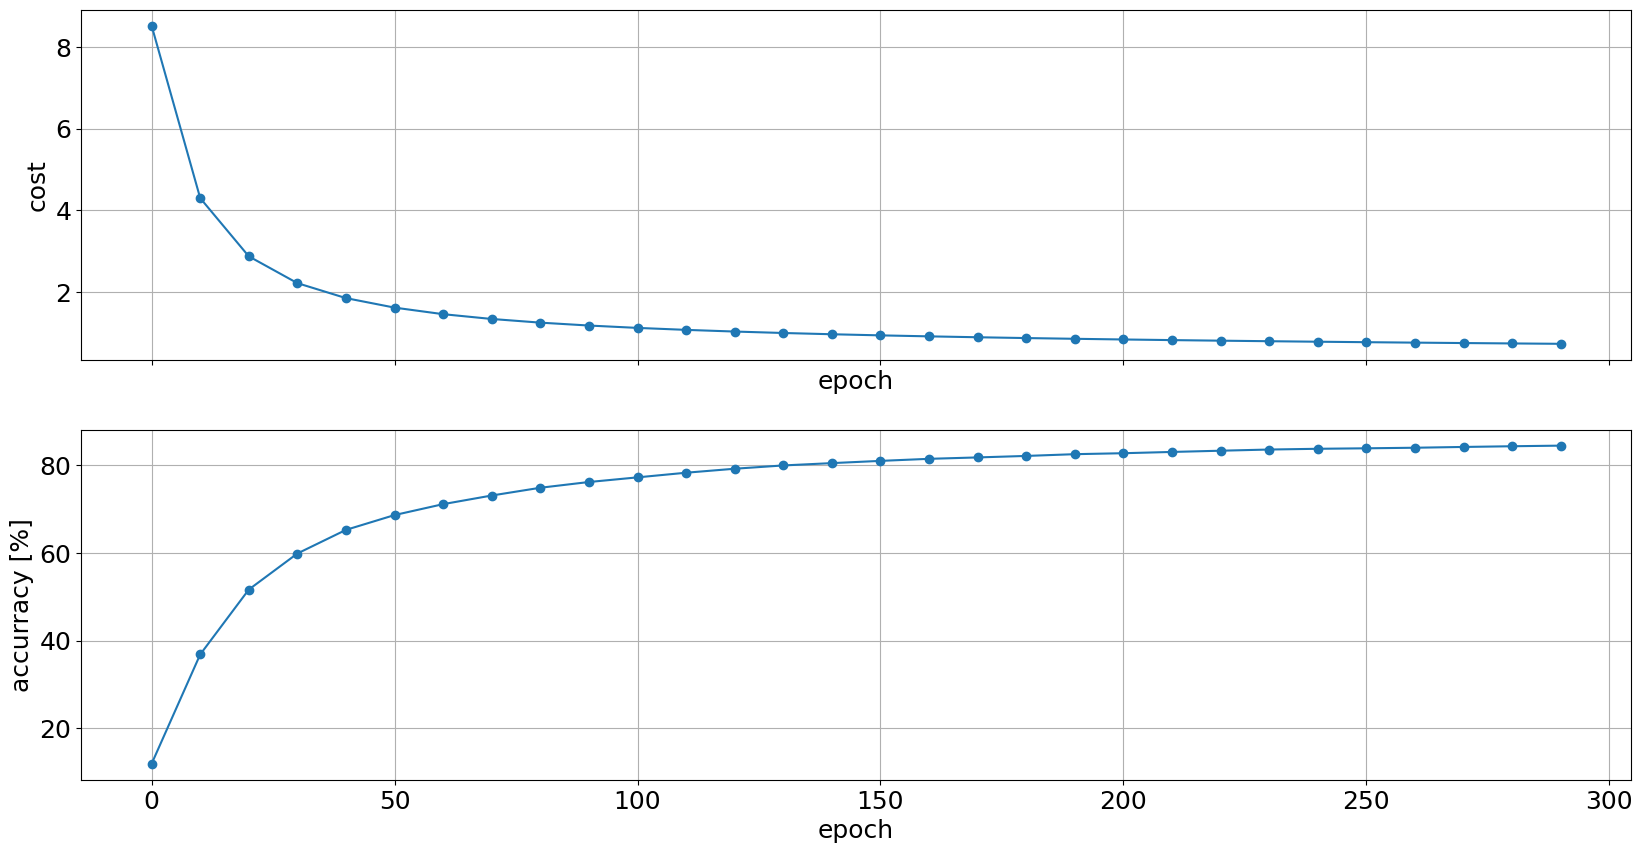

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

Calculam acuratetea pentru setul de date:

In [14]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred: np.ndarray = np.argmax(softmax(test_x_all_ext, theta), axis=1)
actual: np.ndarray = test_y
equalities = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % ( equalities / len(actual) * 100 ))

Test accuracy: 84.65%


Calculam matricea de confuzie (vom avea 10 linii si 10 coloane, fiecare element `conf_matrix[i, j]` = numărul de cazuri în care imaginea aparținea clasei $i$ și a ost prezisă drept aparținând clasei $j$)

In [15]:
from typing import List

# Calculam vectorii predictiilor precum si vectorul realitatii
pred: np.ndarray = np.argmax(softmax(test_x_all_ext, theta), axis=1).astype(int)
actual: np.ndarray = test_y.astype(int)
conf_matrix = np.ndarray = np.zeros((k, k), dtype=int)
for actual_class, predicted_class in zip(actual, pred):
    conf_matrix[actual_class, predicted_class] += 1

assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

    
headers = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] 
table = []
for i in range(k):
    table.append([f'act: {i}'] + list(conf_matrix[i, :]) + [sum(conf_matrix[i, :])]) # instructiune
table.append(["Total"] + np.sum(conf_matrix, axis=1).tolist() + [np.sum(conf_matrix, dtype=int)])


#table.append( ... ) # instructiune
tab.table(table, headers, width=6)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    908 │      1 │     11 │      6 │      0 │     30 │      9 │      5 │      6 │      4 │    980 │
│ act: 1 │      0 │   1076 │      8 │      6 │      3 │      5 │      5 │      1 │     30 │      1 │   1135 │
│ act: 2 │     18 │     23 │    841 │     22 │     16 │     10 │     31 │     22 │     41 │      8 │   1032 │
│ act: 3 │      9 │      2 │     26 │    851 │      3 │     54 │      7 │     13 │     29 │     16 │   1010 │
│ act: 4 │      2 │      2 │     10 │      5 │    830 │      5 │     21 │      6 │     30 │     71 │    982 │
│ act: 5 │     18 │      3 │      8 │     57 │     12 │    666 │     19 │     20 │     79 │     10 │    892 │
│ act: 6 │